How to calculate the Iris code and some examples

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


Find the pupil and iris center for an image

In [2]:
from IrisSegmentation import FindPupilIris, LocateEyelids, LocateEyelids2, EyelidFitter
from util import rgbtogray
%load_ext autoreload
%autoreload 2

#img_use = cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)[: , :, 0] / 255

In [3]:
img = rgbtogray(cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)/255.)

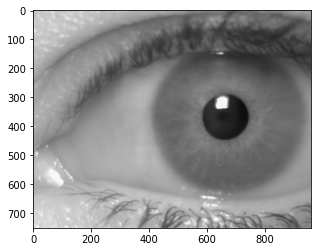

In [4]:
plt.imshow(img, cmap="gray", vmin=0., vmax=1.)

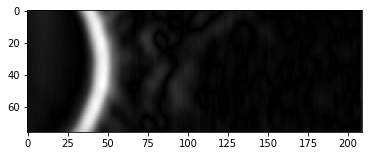

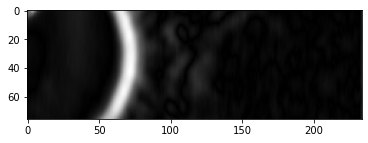

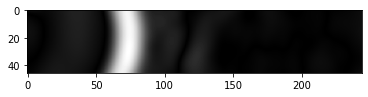

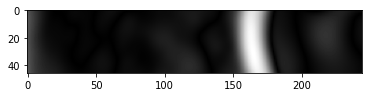

In [5]:
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)

In [6]:
print(pup_center, pup_r, iris_center, iris_r)

(369, 664) 79 (372, 667) 254


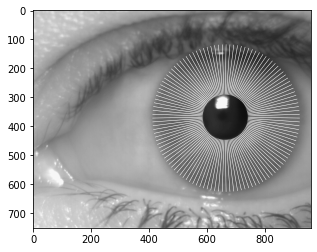

In [7]:
from util import transform_iris
from iriscode import calculate_iris_code
theta_psize = 15
n_theta_patches = 8
rho_psize = 15
n_rho_patches = 8

# It seems like the function FindPupilIris changes img (!), which is passed by refrence. Hence, I reload it here.
img = rgbtogray(cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r,
                            theta_res = theta_psize*n_theta_patches,
                            rho_res = rho_psize*n_rho_patches,
                            method = "Daug", plot = True)


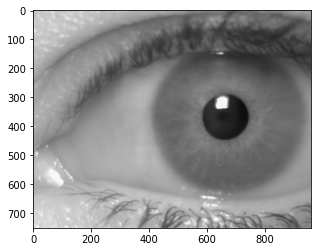

In [8]:
plt.imshow(img, cmap="gray", vmin=0., vmax=1.)

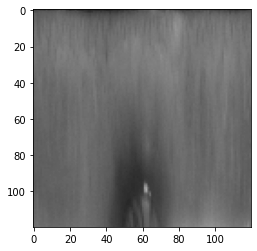

In [9]:
plt.imshow(transf_img, cmap="gray", vmin=0., vmax=1.)

In [10]:
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, 
                alpha=0.4, beta=2.5 omega=4).reshape([n_rho_patches, n_theta_patches*2])

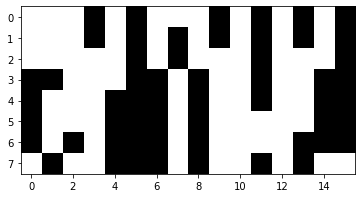

In [11]:
plt.imshow(iriscode, cmap="gray", vmin=0., vmax=1.)


Messing with the parameters alpha and omega will change the code significantly, so the next step is to concatenate the code for various values of alpha and omega and maybe rotations of the iris.

### Rotating the code

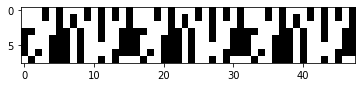

In [12]:
tripple_code = np.concatenate([iriscode, iriscode, iriscode], axis = 1)
plt.imshow(tripple_code, cmap="gray", vmin=0., vmax=1.)


3
0
16
32


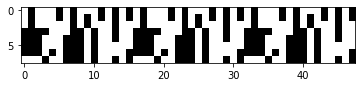

In [111]:

"""
Cycles the iriscode theta wise. Allows for stacked thetas on the column direction.
Takes the iriscode and n_theta_patches used when calculating the code as input.
"""
def cycle_iriscode(iriscode, n_theta_patches):
    n = iriscode.shape[1]
    new_code = np.zeros(iriscode.shape)
    assert(n%n_theta_patches == 0)
    repeats = n//(n_theta_patches*2)
    for i in range(repeats):
        start = i*n_theta_patches*2
        print(start)
        new_code[:, start:start+2*1] = iriscode[:, start + 2*7:start + 2*8]
        new_code[:, start + 2*1: start + 2*8] = iriscode[:, start:start + 2*7]
    return new_code

plt.imshow(cycle_iriscode(tripple_code, n_theta_patches), cmap="gray", vmin=0., vmax=1.)


In [ ]:
plt.imshow(iriscode, cmap="gray", vmin=0., vmax=1.)


Works!

### Make a larger version of the iriscode.

In [39]:
"""
This function will create iriscodes using different filters. The codes are concatenated column-wise
meaning that each filter is separated over (transf_img.shape[1]/theta_psize)*2 columns.
Pairwise determines if the filters are chosen for all pairwise combinations (equal to len(alpha) codes) 
or over all len(alphas)*len(betas)*len(omegas) combinations if False.
"""
def calculate_iriscode_different_filters(transf_img, 
                                         alphas=[0.4, 0.8], betas=[2.5, 1.25], omegas=[4, 8],
                                         theta_psize = 15, rho_psize = 15,
                                         pairwise=True):
    iriscodes = []
    if pairwise:
        assert(len(alphas) == len(betas) and len(betas) == len(omegas))
        for alpha, beta, omega in zip(alphas, betas, omegas):
            code = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, 
                                alpha=alpha, beta=beta, omega=omega)
            iriscodes.append(code)
        return np.concatenate(iriscodes, axis = 1)
    else:
        for alpha in alphas:
            for beta in betas:
                for omega in omegas:
                    code = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, 
                                alpha=alpha, beta=beta, omega=omega)
                    iriscodes.append(code)
        return np.concatenate(iriscodes, axis = 1)

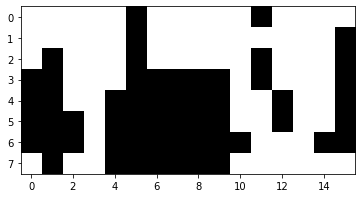

In [221]:
multfilt_code = calculate_iriscode_different_filters(transf_img, alphas=[0.4], betas=[2.5], omegas=[2])
plt.imshow(multfilt_code, cmap="gray", vmin=0., vmax=1.)


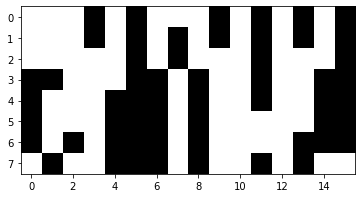

In [15]:
plt.imshow(iriscode, cmap="gray", vmin=0., vmax=1.)


## Testing the code with the same and different eyes.

### Same eye

Using the same settings as above

In [63]:
name1 = "UTIRIS_infrared/021/021_L/Img_021_L_5.bmp"
name2 = "UTIRIS_infrared/021/021_L/Img_021_L_3.bmp"

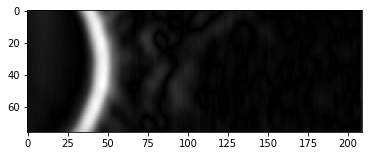

dist right:  52.5
dist right:  52.5


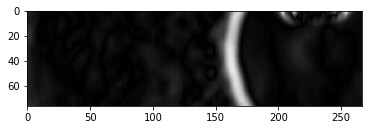

dist left:  103.0


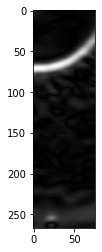

dist top:  73.0


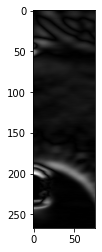

dist bottom:  67.0


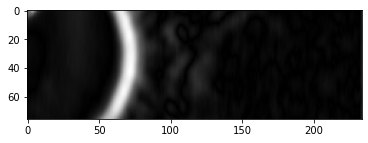

dist right:  77.5
dist right:  77.5


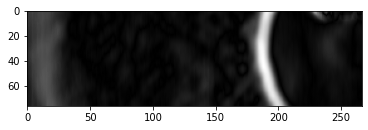

dist left:  78.0


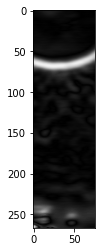

dist top:  74.0


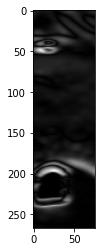

dist bottom:  74.0


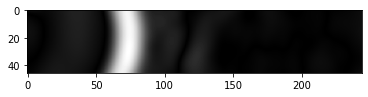

79.0 79.0


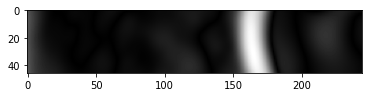

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [375, 670]
Optimal location and radius:  
x=664.0
y=369.0
r=79.0
Estimated iris radius:  234
Optimal location and radius:  
x=671.0
y=376.0
r=258.0


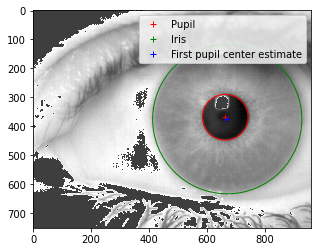

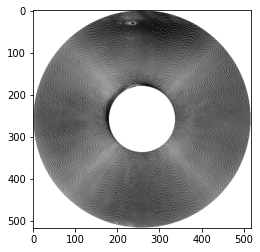

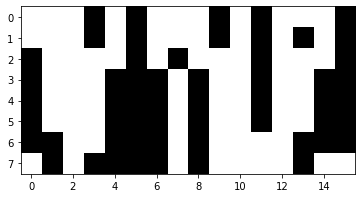

In [64]:
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


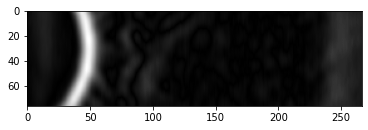

dist right:  55.0


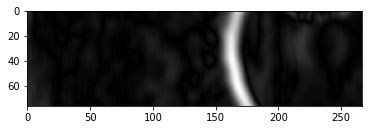

dist left:  102.0


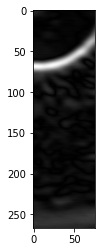

dist top:  71.0


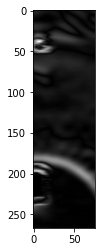

dist bottom:  77.5


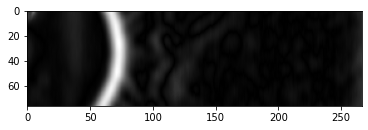

dist right:  79.0


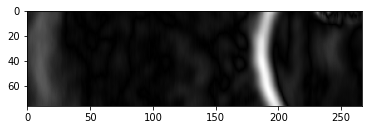

dist left:  78.0


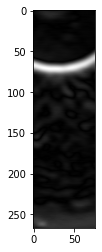

dist top:  78.0


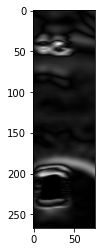

dist bottom:  76.5


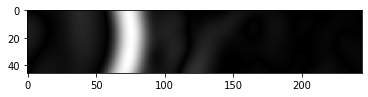

80.0 80.0


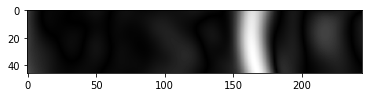

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [359, 577]
Optimal location and radius:  
x=571.0
y=352.0
r=80.0
Estimated iris radius:  239
Optimal location and radius:  
x=579.0
y=361.0
r=263.0


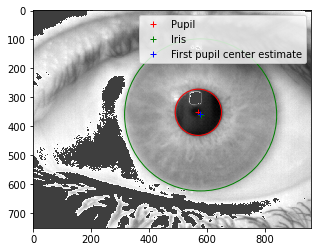

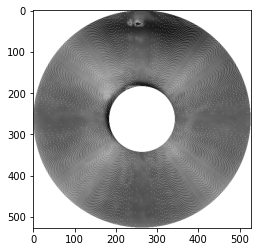

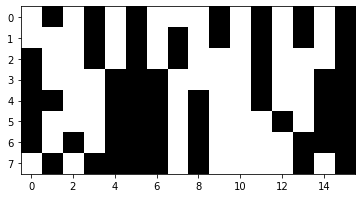

In [65]:
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


They are not exactly the same but there are obviously similarities!

### Different eyes

In [66]:
name1 = "UTIRIS_infrared/021/021_L/Img_021_L_5.bmp"
name2 = "UTIRIS_infrared/062/062_R/Img_062_R_5.bmp"

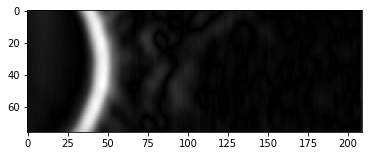

dist right:  52.5
dist right:  52.5


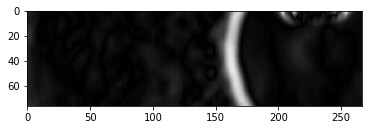

dist left:  103.0


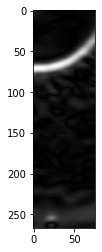

dist top:  73.0


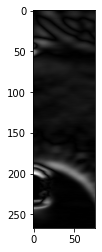

dist bottom:  67.0


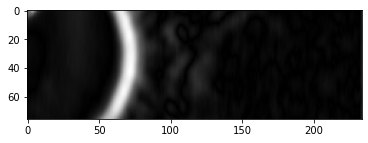

dist right:  77.5
dist right:  77.5


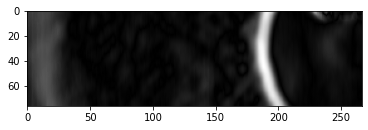

dist left:  78.0


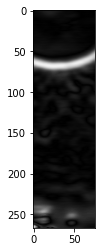

dist top:  74.0


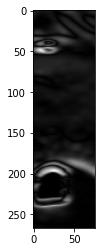

dist bottom:  74.0


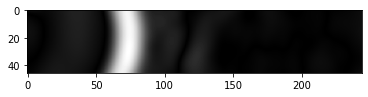

79.0 79.0


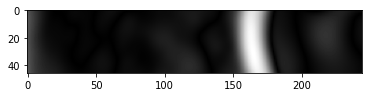

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [375, 670]
Optimal location and radius:  
x=664.0
y=369.0
r=79.0
Estimated iris radius:  234
Optimal location and radius:  
x=671.0
y=376.0
r=258.0


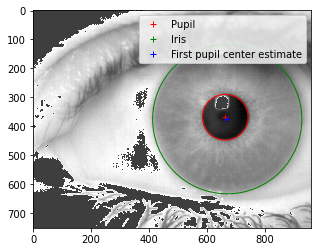

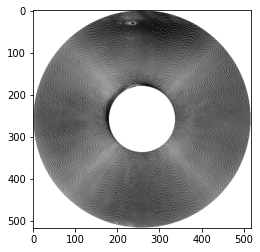

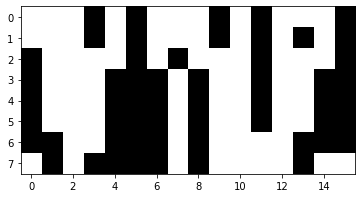

In [67]:
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


In [151]:
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


NameError: name 'name2' is not defined

# Using the the new segmentation

In [190]:
from IrisSegmentation import FastIrisPupilScanner
%load_ext autoreload
%autoreload 2

img_name = "UTIRIS_infrared/021/021_L/Img_021_L_4.bmp"
img = rgbtogray(cv2.imread(img_name).astype(np.double)/255.)
out = FastIrisPupilScanner(img_name)
#plt.imshow(img, cmap="gray")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
print(out)

{'iris': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'iris_xy': (255, 255), 'pupil_xy': (252, 254), 'iris_r': 255, 'pupil_r': 79, 'full_iris': False}


In [192]:
out['iris'].shape

(499, 511)

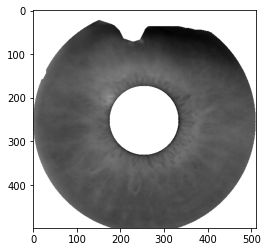

In [193]:
plt.imshow(out['iris'], cmap="gray")

In [87]:
out['iris_xy']

(255, 255)

In [55]:
np.sqrt(2)

1.4142135623730951

In [145]:
def transform_copped_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res, rho_res,
                  method = "Daug", plot = False):
    
    assert(img.ndim == 2)
    if np.max(img) > 1.:
        img = img/255.
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img, cmap="gray", vmin=0., vmax=1.)

    def to_ind(coords):
        return np.array(np.round(coords), dtype="int32")
    
    def outside(img, pos):
        m, n = np.shape(img)
        coord = to_ind(pos)
        if coord[0] < 0 or coord[1] < 0:
            return True
        elif coord[1] >= m or coord[0] >= n:
            return True
        elif (img[coord[1]][coord[0]] - 1.)**2 < 1e-5:
            return True
        else:
            return False
    
    def find_pos_limbus(img, pos, center):
        v = pos - center
        hi = pos
        lo = center
        u = v/np.linalg.norm(v)
        dr = np.sqrt(2)*1.1 # This (should) ensure boundary point
        is_outside = True
        i = 0
        max_iter = 100
        while is_outside and i < max_iter:
            i += 1
            mid = (hi + lo)*0.5
            if outside(img, mid):
                hi = mid
            elif outside(img, mid + u*dr):
                return mid
            else:
                lo = mid
        
        
    tranf = np.zeros([rho_res, theta_res])
    
    if method == "Daug":        
        dtheta = 2*np.pi/theta_res
        thetas = np.arange(0., 2*np.pi, dtheta)
        #assert(np.abs(thetas[-1] - 2.*np.pi) >1e-5)    
        rhos = np.linspace(0., 1., rho_res)
        for j, theta in enumerate(thetas):
            u = np.array([np.cos(theta), np.sin(theta)])
            pos_pup = pup_center + u*pup_r
            
            # There is a high risk that the limbus point is outside of the cropped iris.
            pos_limbus = iris_center + u*iris_r
            if outside(img, pos_limbus):
                pos_limbus = find_pos_limbus(img, pos_limbus, iris_center)
            
            x = (1 - rhos)*pos_pup[0] + rhos*pos_limbus[0]
            y = (1 - rhos)*pos_pup[1] + rhos*pos_limbus[1]
            if plot:
                ax.plot(x, y, color="red", lw=0.5)
            #tranf[:, j] = img[np.flip(to_ind(y)), to_ind(x)]
            
            tranf[:, j] = img[to_ind(y), to_ind(x)]
        return tranf



In [146]:
print(out.keys())

dict_keys(['iris', 'iris_xy', 'pupil_xy', 'iris_r', 'pupil_r', 'full_iris'])


In [147]:
(out['iris']/255)[255, 510]

0.4470588235294118

In [148]:
(out['iris']/255).shape

(504, 511)

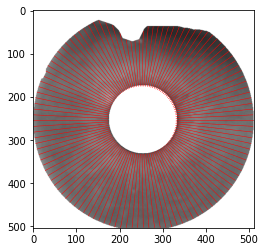

In [149]:
transf_image = transform_copped_iris(out['iris']/255, out['pupil_xy'], out['pupil_r'], out['iris_xy'], out['iris_r'], 
                      theta_res = theta_psize*n_theta_patches, rho_res = rho_psize*n_rho_patches,
                      method = "Daug", plot = True)

seems to work!

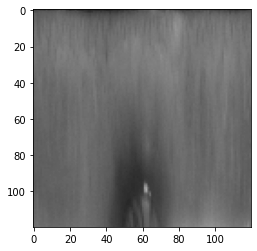

In [150]:
plt.imshow(transf_img, cmap="gray", vmin=0., vmax=1.)

### Creating an iriscode database

Iterating through files

In [188]:
import os
from util import transform_cropped_iris
from IrisSegmentation import FastIrisPupilScanner

import os
ROOTDIR = "UTIRIS_infrared/"
SAVEDIR = "iriscodes/"

def create_iriscodes(rootdir, savedir, alphas=[0.4], betas=[2.5], omegas=[4],
                     code_shape = [8, 8], patch_shape = [15, 15]):
    n_rho_patches = code_shape[0]
    n_theta_patches = code_shape[1]
    rho_psize = patch_shape[0]
    theta_psize = patch_shape[1]
    codes = []
    names = []
    i = 1
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.endswith(".bmp"):
                #print(file)
                print(f"iter {i}...")
                i+=1
                image_name = os.path.join(subdir, file)
                try:
                    out = FastIrisPupilScanner(image_name)
                except IndexError:
                    print(f"Warning, IndexError for {image_name}")
                    continue
                try:
                    transf_image = transform_copped_iris(out['iris']/255, 
                                                     out['pupil_xy'], out['pupil_r'],
                                                     out['iris_xy'], out['iris_r'], 
                                                     theta_res = theta_psize*n_theta_patches,
                                                     rho_res = rho_psize*n_rho_patches)
                except TypeError:
                    print(f"Warning, TypeError for {image_name}, pupil: c{out['pupil_xy']} r{out['pupil_r']}, iris: c{out['iris_xy']} r{out['iris_r']}")
                    continue
                code = calculate_iriscode_different_filters(transf_image, 
                                         alphas=alphas, betas=betas, omegas=omegas,
                                         theta_psize = theta_psize, rho_psize = rho_psize,
                                         pairwise=True)
                codes.append(code)
                names.append(f"{savedir}{file[:-4]}.npy")
                if i%100 == 0:
                    assert(len(codes) == len(names))
                    for name, code in zip(names, codes):
                        np.save(name, code)
                    codes = []
                    names = []

In [189]:
create_iriscodes(ROOTDIR, SAVEDIR)

iter 1...
iter 2...
iter 3...
iter 4...
iter 5...
iter 6...
iter 7...
iter 8...
iter 9...
iter 10...
iter 11...
iter 12...
iter 13...
Warning, IndexError for UTIRIS_infrared/032/032_R/Img_032_R_3.bmp
iter 14...
Warning, IndexError for UTIRIS_infrared/032/032_R/Img_032_R_2.bmp
iter 15...
iter 16...
iter 17...
iter 18...
iter 19...
iter 20...
iter 21...
Warning, TypeError for UTIRIS_infrared/010/010_L/Img_010_R_4_1.bmp, pupil: c(229, 239) r118, iris: c(234, 234) r234
iter 22...
Warning, TypeError for UTIRIS_infrared/010/010_L/Img_010_R_2_1.bmp, pupil: c(243, 233) r119, iris: c(238, 238) r238
iter 23...
iter 24...
iter 25...
Warning, TypeError for UTIRIS_infrared/010/010_L/Img_010_R_3_1.bmp, pupil: c(234, 239) r118, iris: c(238, 238) r238
iter 26...
iter 27...
iter 28...
iter 29...
Warning, TypeError for UTIRIS_infrared/010/010_R/Img_010_L_4.bmp, pupil: c(238, 238) r120, iris: c(239, 239) r239
iter 30...
Warning, TypeError for UTIRIS_infrared/010/010_R/Img_010_L_1.bmp, pupil: c(247, 240) 

Warning, TypeError for UTIRIS_infrared/062/062_R/Img_062_R_5.bmp, pupil: c(245, 271) r117, iris: c(241, 266) r266
iter 187...
iter 188...
iter 189...
iter 190...
iter 191...
iter 192...
iter 193...
iter 194...
iter 195...
iter 196...
iter 197...
iter 198...
iter 199...
iter 200...
Warning, TypeError for UTIRIS_infrared/027/027_R/Img_027_R_5.bmp, pupil: c(257, 266) r147, iris: c(262, 262) r262
iter 201...
Warning, TypeError for UTIRIS_infrared/027/027_R/Img_027_R_4.bmp, pupil: c(272, 368) r149, iris: c(268, 366) r366
iter 202...
iter 203...
iter 204...
Warning, TypeError for UTIRIS_infrared/027/027_R/Img_027_R_2.bmp, pupil: c(265, 268) r146, iris: c(266, 266) r266
iter 205...
Warning, TypeError for UTIRIS_infrared/027/027_L/Img_027_L_5.bmp, pupil: c(272, 285) r146, iris: c(269, 288) r288
iter 206...
iter 207...
Warning, TypeError for UTIRIS_infrared/027/027_L/Img_027_L_2.bmp, pupil: c(265, 274) r147, iris: c(270, 270) r270
iter 208...
Warning, TypeError for UTIRIS_infrared/027/027_L/Img

iter 344...
iter 345...
iter 346...
iter 347...
Warning, TypeError for UTIRIS_infrared/067/067_L/Img_067_L_1_1.bmp, pupil: c(278, 281) r147, iris: c(283, 283) r283
iter 348...
iter 349...
iter 350...
iter 351...
iter 352...
iter 353...
iter 354...
iter 355...
iter 356...
iter 357...
Warning, TypeError for UTIRIS_infrared/003/003_R/Img_003_R_1.bmp, pupil: c(202, 285) r112, iris: c(207, 280) r280
iter 358...
iter 359...
Warning, IndexError for UTIRIS_infrared/003/003_R/Img_003_R_3.bmp
iter 360...
iter 361...
iter 362...
iter 363...
iter 364...
iter 365...
iter 366...
iter 367...
iter 368...
iter 369...
iter 370...
iter 371...
iter 372...
Warning, IndexError for UTIRIS_infrared/048/048_R/Img_048_R_4_1.bmp
iter 373...
Warning, IndexError for UTIRIS_infrared/048/048_R/Img_048_R_1_1.bmp
iter 374...
Warning, IndexError for UTIRIS_infrared/048/048_R/Img_048_R_3_1.bmp
iter 375...
iter 376...
iter 377...
iter 378...
iter 379...
iter 380...
iter 381...
iter 382...
iter 383...
iter 384...
iter 385

IndexError: index 401 is out of bounds for axis 0 with size 400

### Make a nice class

In [ ]:
class ICodeDatabase